# Diffusion Illusions: Twisting Squares

Hi! Welcome to the official colab demo for our demo "Diffusion Illusions: Hiding Images in Plain Sight"

By Ryan Burgert, Xiang Li, Abraham Leite, Kanchana Ranasinghe and Michael Ryoo from Stony Brook University

Visit our project website: [diffusionillusions.com](https://ryanndagreat.github.io/Diffusion-Illusions/)

This project was inspired by our paper "Peekaboo: Text to Image Diffusion Models are Zero-Shot Segmentors". The Peekaboo project website: [https://ryanndagreat.github.io/peekaboo/](https://ryanndagreat.github.io/peekaboo/)

Instructions:

0. Go to the Runtime menu, and make sure this notebook is using GPU!
1. Run the top 2 code cells (one cleans colab's junk and downloads the source code, while the other installs python packages)
2. Click 'Runtime', then 'Restart Runtime'. You need to do this the first time you open this notebook to avoid weird random errors from the pip installations.
3. Run code cells to load stable diffusion. The first time you run it it will take a few minutes to download; subsequent times won't take long at all though.
4. Run all the cells below that, and customize prompt_a and prompt_b!
5. Take the result top_image and bottom_image, print them out, and shine a backlight through them like shown in the Diffusion Illusion website (link above!)

I may also create a YouTube tutorial if there's interest. Let me know if this would be helpful!

This notebook was written by Ryan Burgert. Feel free to reach out to me at rburgert@cs.stonybrook.edu if you have any questions!

In [1]:
%%bash
if [ ! -d ".git" ]; then
    rm -rf * .*; #Get rid of Colab's default junk files
    git clone -b master https://github.com/RyannDaGreat/Diffusion-Illusions .
fi

rm: refusing to remove '.' or '..' directory: skipping '.'
rm: refusing to remove '.' or '..' directory: skipping '..'
Cloning into '.'...


In [2]:
%pip install --upgrade -r requirements.txt
%pip install rp --upgrade
# You may need to restart the runtime after installing these
# I'm not sure why this helps, but all sorts of weird random errors pop up in Colab if you don't

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 118.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached oldest_supported_numpy-2023.12.21-py3-none-any.whl.metadata (9.8 kB)
  Using cached numpy-1.26.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
#SET YOUR PROMPTS HERE

prompt_a = "Hatsune Miku"
prompt_b = "A dog's face photograph 4k"

NUMBER_OF_SQUARES = 4 # A 4x4 twisting squares illusion

#Optional: Specify what you DON'T want to see
negative_prompt = 'blurry ugly'

print()
print('Negative prompt:',repr(negative_prompt))
print()
print('Chosen prompts:')
print('    prompt_a =', repr(prompt_a)) #This will be right-side up
print('    prompt_b =', repr(prompt_b)) #This will be upside-down


Negative prompt: 'blurry ugly'

Chosen prompts:
    prompt_a = 'Hatsune Miku'
    prompt_b = "A dog's face photograph 4k"


In [16]:
from rp import *
import numpy as np
import rp
import torch
import torch.nn as nn
import source.stable_diffusion as sd
from easydict import EasyDict
from source.learnable_textures import LearnableImageFourier
from source.stable_diffusion_labels import NegativeLabel
from itertools import chain
import time

In [17]:
if 's' not in dir():
    #You can select the original Stable Diffusion 1.5 or some dreambooth of it
    model_name="CompVis/stable-diffusion-v1-4"
    model_name="runwayml/stable-diffusion-v1-5"
    # model_name="nitrosocke/Arcane-Diffusion"
    gpu=rp.select_torch_device()
    s=sd.StableDiffusion(gpu,model_name)
device=s.device

In [18]:
label_a = NegativeLabel(prompt_a,negative_prompt)
label_b = NegativeLabel(prompt_b,negative_prompt)

In [19]:
#Image Parametrization and Initialization (this section takes vram)

#Select Learnable Image Size (this has big VRAM implications!):
#Note: We use implicit neural representations for better image quality
#They're previously used in our paper "TRITON: Neural Neural Textures make Sim2Real Consistent" (see tritonpaper.github.io)
# ... and that representation is based on Fourier Feature Networks (see bmild.github.io/fourfeat)
learnable_image_maker = lambda: LearnableImageFourier(height=256,width=256,num_features=256,hidden_dim=256,scale=10).to(s.device);SIZE=256

image=learnable_image_maker()

In [20]:
import torch
import torch.nn.functional as F

def rotate_tiles(image, num_divisions=NUMBER_OF_SQUARES):
    image=as_torch_image(image)
    # Assuming image is a tensor of shape (num_channels, height, width)
    num_channels, height, width = image.shape

    tile_size=width//num_divisions

    # Calculate the number of tiles in each dimension
    tiles_x = width // tile_size
    tiles_y = height // tile_size

    # Initialize an output tensor
    output = torch.zeros_like(image)

    for x in range(tiles_x):
        for y in range(tiles_y):
            # Extract the tile
            tile = image[:, y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size]

            # Check if the tile should be rotated 90 or -90 degrees (checker pattern)
            if (x + y) % 2 == 0:
                # Rotate 90 degrees
                tile = tile.rot90(1, [1, 2])
            else:
                # Rotate -90 degrees
                tile = tile.rot90(-1, [1, 2])

            # Place the rotated tile back in the output tensor
            output[:, y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size] = tile

    return output

learnable_image_a=lambda: image()
learnable_image_b=lambda: rotate_tiles(image()) #Upside-down

optim=torch.optim.SGD(image.parameters(),lr=1e-4)

In [21]:
labels=[label_a,label_b]
learnable_images=[learnable_image_a,learnable_image_b]

#The weight coefficients for each prompt. For example, if we have [0,1], then only the upside-down mode will be optimized
weights=[1,1]

weights=rp.as_numpy_array(weights)
weights=weights/weights.sum()
weights=weights*len(weights)

In [22]:
#For saving a timelapse
ims=[]

In [23]:
def get_display_image():
    return rp.tiled_images(
        [
            rp.as_numpy_image(learnable_image_a()),
            rp.as_numpy_image(learnable_image_b()),
        ],
        length=len(learnable_images),
        border_thickness=0,
    )

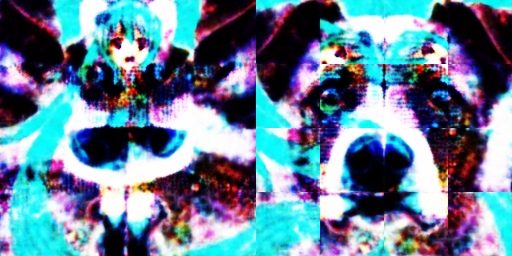

Every 200 iterations we display an image in the form [image_a, image_b], where
    image_a = (the right-side up image)
    image_b = (image_a, but upside down)

Interrupt the kernel at any time to return the currently displayed image
You can run this cell again to resume training later on

Please expect this to take quite a while to get good images (especially on the slower Colab GPU's)! The longer you wait the better they'll be


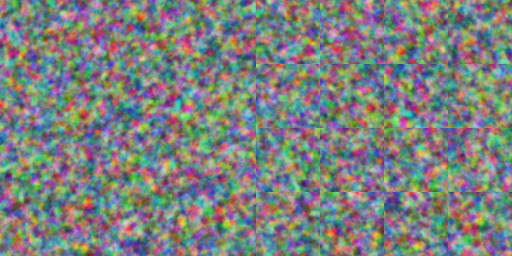

Status: ETR=1:33:45.622221      ETA=1:37:40.023147      T=0:03:54.400926        Progress: 200/5000      RATE=0.85/s

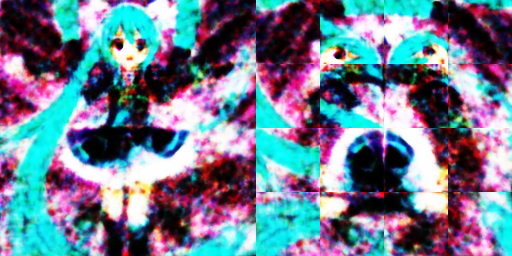

Status: ETR=1:29:52.383997      ETA=1:37:41.286953      T=0:07:48.902956        Progress: 400/5000      RATE=0.85/s

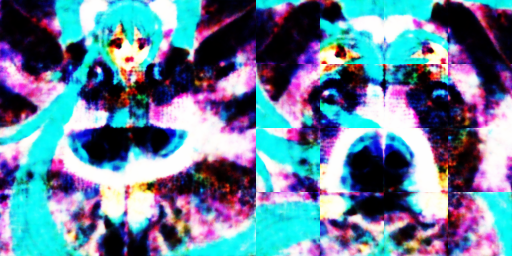

Status: ETR=1:28:21.972746      ETA=1:37:39.828411      T=0:09:17.855665        Progress: 476/5000      RATE=0.85/s
Interrupted early at iteration 476


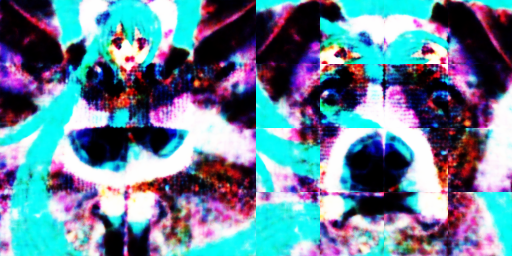

In [24]:
NUM_ITER=5000

#Set the minimum and maximum noise timesteps for the dream loss (aka score distillation loss)
s.max_step=MAX_STEP=990
s.min_step=MIN_STEP=10

television = rp.JupyterDisplayChannel()
television.display()

display_eta=rp.eta(NUM_ITER, title='Status')

DISPLAY_INTERVAL = 200

print('Every %i iterations we display an image in the form [image_a, image_b], where'%DISPLAY_INTERVAL)
print('    image_a = (the right-side up image)')
print('    image_b = (image_a, but upside down)')
print()
print('Interrupt the kernel at any time to return the currently displayed image')
print('You can run this cell again to resume training later on')
print()
print('Please expect this to take quite a while to get good images (especially on the slower Colab GPU\'s)! The longer you wait the better they\'ll be')

try:
    for iter_num in range(NUM_ITER):
        display_eta(iter_num) #Print the remaining time

        preds=[]
        for label,learnable_image,weight in rp.random_batch(list(zip(labels,learnable_images,weights)), batch_size=1):
            pred=s.train_step(
                label.embedding,
                learnable_image()[None],

                #PRESETS (uncomment one):
                noise_coef=.1*weight,guidance_scale=100,#10
                # noise_coef=0,image_coef=-.01,guidance_scale=50,
                # noise_coef=0,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1,image_coef=-.010,guidance_scale=50,
                # noise_coef=.1,image_coef=-.005,guidance_scale=50,
                # noise_coef=.1*weight, image_coef=-.005*weight, guidance_scale=50,
            )
            preds+=list(pred)

        with torch.no_grad():
            if iter_num and not iter_num%(DISPLAY_INTERVAL*50):
                #Wipe the slate every 50 displays so they don't get cut off
                from IPython.display import clear_output
                clear_output()

            if not iter_num%(DISPLAY_INTERVAL//4):
                im = get_display_image()
                ims.append(im)
                television.update(im)

                if not iter_num%DISPLAY_INTERVAL:
                    rp.display_image(im)

        optim.step()
        optim.zero_grad()
except KeyboardInterrupt:
    print()
    print('Interrupted early at iteration %i'%iter_num)
    im = get_display_image()
    ims.append(im)
    rp.display_image(im)

Unsolved Image:


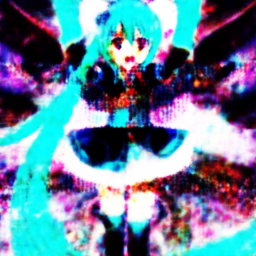

Solved Image:


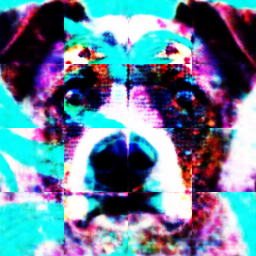

In [25]:
print('Unsolved Image:')
rp.display_image(rp.as_numpy_image(learnable_image_a()))

print('Solved Image:')
rp.display_image(rp.as_numpy_image(learnable_image_b()))

In [26]:
def save_run(name):
    folder="untracked/parker_puzzle_runs/%s"%name
    if rp.path_exists(folder):
        folder+='_%i'%time.time()
    rp.make_directory(folder)
    ims_names=['ims_%04i.png'%i for i in range(len(ims))]
    with rp.SetCurrentDirectoryTemporarily(folder):
        rp.save_images(ims,ims_names,show_progress=True)
    print()
    print('Saved timelapse to folder:',repr(folder))

save_run('-'.join([prompt_a,prompt_b])) #You can give it a good custom name if you want!

Saving Images: Done! Did 11 items in 0:00:00.354888
rp.save_images: Done! Saved 11 images in 0.357 seconds

Saved timelapse to folder: "untracked/parker_puzzle_runs/Hatsune Miku-A dog's face photograph 4k"
